# CS156 Assignment 4 

In [34]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt

# create paths for all images
man_clothes = glob('man_300/*')
woman_clothes = glob('woman_300/*')

## Data Preprocessing

In [35]:
def image_resize(images, size):
    """
    This function is used from Session 7.1 where we use to 
    resize images. We will be scaling the images to 384 x 512 pixels
    """
    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, size)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))

    # Flatten it once more
    flattened = np.asarray(flattened, dtype = object)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    return X, Y


In [36]:
%%time

size = [50,150]

man_images = image_resize(man_clothes, size)[0]
woman_images = image_resize(woman_clothes, size)[0]

#Check data shape 
print(man_images.shape) 
print(woman_images.shape) 

(300, 22500)
(300, 22500)
CPU times: user 2.72 s, sys: 76.3 ms, total: 2.8 s
Wall time: 2.81 s


In [44]:
## Add classes and merge data 

# Add 1 for men and 0 for women classes 
new_column_ones = np.ones((len(man_images), 1))
new_column_zeros = np.zeros((len(man_images), 1))

class_man_images = np.append(man_images, new_column_ones, axis = 1)
class_woman_images = np.append(woman_images, new_column_zeros, axis = 1)

print(class_man_images.shape)
print(class_woman_images.shape)

images_data = np.concatenate((class_man_images, class_woman_images), axis = 0)

print(images_data.shape)

(300, 22501)
(300, 22501)
(600, 22501)


In [57]:
from sklearn.model_selection import train_test_split

X = images_data[:, 0:-1] # select all except the last column 
y = images_data[:, -1] # select last column 

print(X.shape)
print(y.shape)

# Splitting training and testing for 80% and 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

print("Split data: ")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(600, 22500)
(600,)
Split data: 
(480, 22500)
(120, 22500)
(480,)
(120,)


## Using Logistic Regression without PCA or LDA 

In [ ]:
from sklearn.linear_model import LogisticRegression 


In [90]:
%%time 
#6.44s 

logreg = LogisticRegression(max_iter=600) # < 600 iter does not converge 

logreg.fit(X_train, y_train)

logreg_pred = logreg.predict(X_test)

CPU times: user 1min 3s, sys: 3.96 s, total: 1min 7s
Wall time: 6.66 s


In [91]:
# Acquire Metrics 
logreg_training_score = logreg.score(X_train, y_train)
logreg_testing_score = logreg.score(X_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_training_score)
print("Testing Score:", logreg_testing_score)

---SCORES---
Training Score: 1.0
Testing Score: 0.6333333333333333


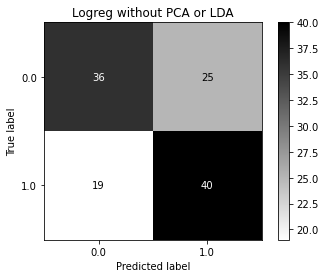

In [92]:
from sklearn import metrics

metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap = 'binary')
plt.title("Logreg without PCA or LDA")
plt.show()

## Logistic Regression with PCA 

As the first step, we would just like to check on how the trend of the scree plot behaves when we apply PCA. Here we just test up until 20 n_components since beyond that would just be purely flat variance and would be really small to see. 

Data shape: (480, 20) (120, 20)


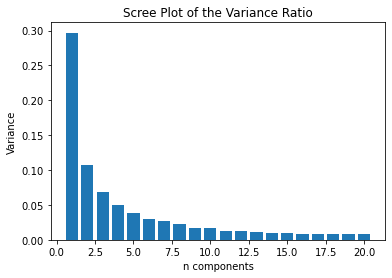

In [141]:
# Checking how PCA works out on the scree plot 
from sklearn import decomposition

# We will by looking at how much variance we get 
n_components = 20

pca = decomposition.PCA(n_components = n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.fit_transform(X_test)

print("Data shape:", X_PCA_train.shape, X_PCA_test.shape)

# Plot the variance on a scree plot 
def plot_scree(n_comp, pca_var):
    plt.bar(np.linspace(1, n_comp, n_comp),pca_var)

    plt.title("Scree Plot of the Variance Ratio")
    plt.xlabel("n components")
    plt.ylabel("Variance")

    plt.show()
    
plot_scree(n_components, pca.explained_variance_ratio_)



In [142]:
%%time 
#6.44s 

logreg = LogisticRegression(max_iter=100)

logreg.fit(X_PCA_train, y_train)

logreg_pred = logreg.predict(X_PCA_test)

CPU times: user 55.9 ms, sys: 28 ms, total: 83.9 ms
Wall time: 10.7 ms


In [143]:
# Acquire Metrics 
logreg_training_score = logreg.score(X_PCA_train, y_train)
logreg_testing_score = logreg.score(X_PCA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_training_score)
print("Testing Score:", logreg_testing_score)

---SCORES---
Training Score: 0.65
Testing Score: 0.6


In [133]:
def PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps): 
    """
    This function aims to check on the training and testing 
    scores with varying n_commponents set for the PCA. 
    
    Input: data 
    Output: Training and testing scores 
    """
    # Metrics 
    training_scores = []
    testing_scores = []
    
    for n in n_comps: 
        # Fit PCA 
        pca = decomposition.PCA(n_components = n)
        X_PCA_train = pca.fit_transform(X_train)
        X_PCA_test = pca.fit_transform(X_test)
        
        # Fit LogReg 
        logreg = LogisticRegression(max_iter=100)
        logreg.fit(X_PCA_train, y_train)
        
        training_scores.append(logreg.score(X_PCA_train, y_train))
        testing_scores.append(logreg.score(X_PCA_test, y_test))
        
    return training_scores, testing_scores 

In [135]:
%%time 

# Get number of components 
n_comps = np.linspace(1, 99, 99).astype('int64')

training_scores, testing_scores = PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps)

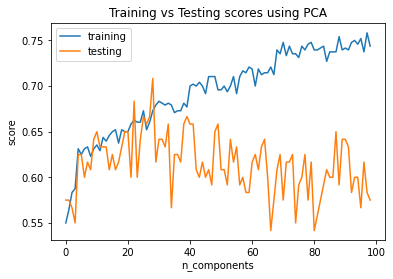

In [136]:
# Plot results 

plt.plot(training_scores, label = 'training')
plt.plot(testing_scores, label = 'testing')
plt.title("Training vs Testing scores using PCA")
plt.xlabel("n_components")
plt.ylabel("score")
plt.legend()
plt.show()

**NOTES**

1 - 20: training and testing score increasing together 

20 - 40: good measure of n_components with high testing score 

40 and beyond: starting to overfit 

## Logistic Regression with LDA 

In [144]:
# Implement LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [161]:
# Fitting LDA 
lda_train = LinearDiscriminantAnalysis()
lda_test = LinearDiscriminantAnalysis()

X_LDA_train = lda_train.fit_transform(X_train, y_train)
X_LDA_test = lda_test.fit_transform(X_test, y_test)




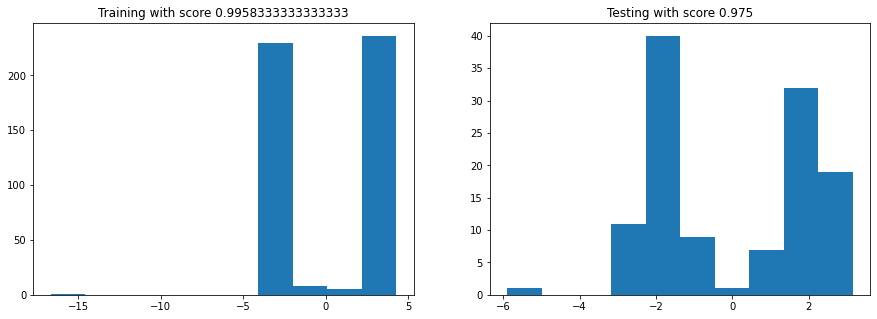

In [162]:
# See how our LDA performs 

fig, ax = plt.subplots(1,2, figsize = [15,5])

ax[0].hist(X_LDA_train)
ax[0].set_title(f"Training with score {lda_train.score(X_train,y_train)}") 
ax[1].hist(X_LDA_test)
ax[1].set_title(f"Testing with score {lda_test.score(X_test,y_test)}")

plt.show()

In [163]:
# Implementing with LogReg 

logreg = LogisticRegression(max_iter=100)

logreg.fit(X_LDA_train, y_train)

logreg_pred = logreg.predict(X_LDA_test)

# Acquire Metrics 
logreg_training_score = logreg.score(X_LDA_train, y_train)
logreg_testing_score = logreg.score(X_LDA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_training_score)
print("Testing Score:", logreg_testing_score)

---SCORES---
Training Score: 0.9958333333333333
Testing Score: 0.975
